In [7]:
import numpy as np 
import argparse

filename   = str("bin_files/002_00000001.bin")
pointcloud = np.fromfile(filename, dtype=np.float32)
pointcloud = pointcloud.reshape([-1,4])

print('LiDAR data loaded as a variable pointcloud')

str1= str('\nLidar data file : ') + str(filename) + str('\nSize of pointcloud data = ') + str(pointcloud.shape)
print(str1)

LiDAR data loaded as a variable pointcloud

Lidar data file : bin_files/002_00000001.bin
Size of pointcloud data = (92246, 4)


In [8]:
def visualize_3d(pointcloud,cloud_color,Point_size):
    import pptk
    import numpy as np 
    
    # Extract first three points as x y z inputs and 4th for reflectivity value
    P = pointcloud[:,0:3]
    
    a = pointcloud.shape[0]
    R = np.ones((a))*20
    
    if pointcloud.shape[1]==4:
        R   = pointcloud[:,3]
    
    # define color channels
    rgb = np.ones((P.shape))*cloud_color    # for grayish effect [200,200,200]
    
    rgb[:,0] = rgb[:,0]*(255-R)/255
    rgb[:,1] = rgb[:,1]*(255-R)/255
    rgb[:,2] = rgb[:,2]*(255-R)/255
    
    if len(cloud_color)>3:
        rgb = cloud_color
    
    # Visualize point cloud
    v = pptk.viewer(P)
    v.attributes(rgb / 255, R)
    v.set(floor_color = [0,0,0,0.5])
    v.set(show_grid=0)
    v.set(lookat = [0,0,0])             # set zero /ego vehicle coordinate
    v.set(point_size=Point_size)        # for better visualization point_size = 0.001
    v.color_map('cool', scale=[0, 5])
    v.color_map([[0, 0, 0], [1, 1, 1]])

In [9]:
import pcl

cloud = pcl.PointCloud(np.array(pointcloud[:,0:3], dtype=np.float32))
seg   = cloud.make_segmenter_normals(ksearch=50)

seg.set_optimize_coefficients(True)
seg.set_model_type(pcl.SACMODEL_PLANE)
seg.set_normal_distance_weight(0.07)
seg.set_method_type(pcl.SAC_RANSAC)

seg.set_max_iterations(100)
seg.set_distance_threshold(0.25)

inliers, model = seg.segment()

if len(inliers) == 0:
        print('Could not estimate a planar model for the given dataset.')
        exit(0)

#Points here is a nx3 numpy array with n 3d points. 
#Model will be [a, b, c, d] such that ax + by + cz + d = 0
print('Model coefficients: ' + str(model[0]) + ' ' + str(model[1]) + ' ' + str(model[2]) + ' ' + str(model[3]))
print('Model inliers: ' + str(len(inliers)))
print(len(model))

Model coefficients: 0.0145805468783 0.00373710296117 0.99988669157 1.55821990967
Model inliers: 39196
4


### Simple top view projection of all pointcloud points ( x,y co-ordinates )

In [10]:
def point_cloud_top_view(velo,fwd_range,side_range,height_range,name = 'fig_name'):
    
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from PIL import Image
    import numpy as np 
    
    x_points = velo[:, 0]
    y_points = velo[:, 1]
    z_points = velo[:, 2]
    r        = velo[:, 3]
    
    f_filt   = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt   = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
    filter   = np.logical_and(f_filt, s_filt)
    indices  = np.argwhere(filter).flatten()
    
    # KEEPERS
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]
    r_points = r[indices]
    
    res      = 0.05
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img    = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img    = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR
    
    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor and ceil used to prevent anything being rounded to below 0 after shift
    x_img   -= int(np.floor(side_range[0] / res))
    y_img   += int(np.ceil(fwd_range[1] / res))

    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a     = z_points,
                           a_min = height_range[0],
                           a_max = height_range[1])
    
    def scale_to_255(a, min, max, dtype = np.uint8):
        return (((a - min) / float(max - min)) * 255).astype(dtype)

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values  = scale_to_255(pixel_values, min = height_range[0], max = height_range[1])
    
    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1+int((side_range[1] - side_range[0])/res)
    y_max = 1+int((fwd_range[1] - fwd_range[0])/res)
    im    = np.zeros([y_max, x_max], dtype=np.uint8)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[y_img, x_img]   =r_points # pixel_values
        
    plt.figure(figsize = (10,10))
    a = plt.imshow(im,vmin = 0, vmax=255)
    
    ax = plt.gca()
    rect = Rectangle((580,565),40,70,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #plt.text(600,575, "Ego Vehicle",horizontalalignment='center',rotation='vertical',color='red')
    
    return a

In [11]:
abc = np.arange(0,pointcloud.shape[0],1)
outliers = np.delete(abc,inliers)
# Visualize off ground plane points
off_ground_pointcloud = pointcloud[outliers,:]

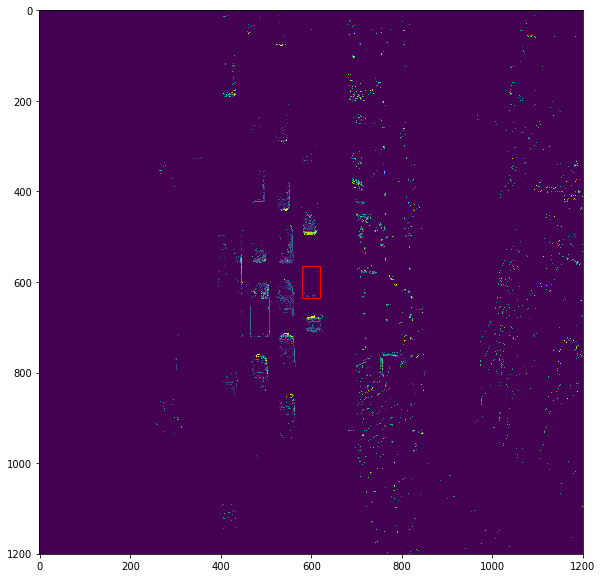

In [12]:
side_range   = (-30, 30)  # left-most to right-most
fwd_range    = (-30, 30)    # back-most to forward-most
height_range = (-3, 5)  # bottom-most to upper-most
fig_name     = str('point_cloud_data_top_view')

a = point_cloud_top_view(off_ground_pointcloud,fwd_range,side_range,height_range,name ='fig_name')

### Ground plane projection of off ground pointcloud points ( gives x,y,z co-ordinates )

In [13]:
a = model[0]
b = model[1]
c = model[2]
d = model[3]
u = off_ground_pointcloud[:,0]
v = off_ground_pointcloud[:,1]
w = off_ground_pointcloud[:,2]

ground_projection_pointcloud = np.zeros([off_ground_pointcloud.shape[0],3])

for i in range(off_ground_pointcloud.shape[0]):
    ground_projection_pointcloud[i,0]= u[i] - a*(a*u[i]+b*v[i]+c*w[i]+d)/(a*a+b*b+c*c)
    ground_projection_pointcloud[i,1]= v[i] - b*(a*u[i]+b*v[i]+c*w[i]+d)/(a*a+b*b+c*c)
    ground_projection_pointcloud[i,2]= w[i] - c*(a*u[i]+b*v[i]+c*w[i]+d)/(a*a+b*b+c*c)

In [14]:
visualize_3d(ground_projection_pointcloud,[200,200,200],0.005)